<a href="https://colab.research.google.com/github/arvind2047/gl_capstone/blob/temp_repo_siva/Ticket_classif.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-gpu >> /dev/null

In [2]:
!pip install --upgrade grpcio >> /dev/null

In [3]:
!pip install tqdm >> /dev/null

In [4]:
!pip install bert-for-tf2 >> /dev/null

In [5]:
!pip install sentencepiece >> /dev/null

In [6]:
import os
import math
import datetime

from tqdm import tqdm

import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np

import tensorflow as tf
from tensorflow import keras

import bert
from bert import BertModelLayer
from bert.loader import StockBertConfig, map_stock_config_to_params, load_stock_weights
from bert.tokenization.bert_tokenization import FullTokenizer

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import rc

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.cluster import AgglomerativeClustering

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid',palette='muted',font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE","#FFDD00","#FF7D00","#FF006D","#ADFF02","#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize']=12,8

RANDOM_SEED=42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [8]:
project_path = '/content/drive/My Drive/GL AIML Capstone/' 
os.chdir(project_path) 
os.getcwd()

'/content/drive/My Drive/GL AIML Capstone'

In [9]:
import pickle

with open('incidents_text.pickle', 'rb') as data:
    incidents = pickle.load(data)

In [10]:
incidents.head(2)

,Description,Caller,Assignment group,desc_len,desc_word_cnt,tokens,Group id,embedding,class
0,login issue verified user details employee manager name checked the user name in ad and reset the password advised the user to login and check caller confirmed that he was able to login issue resolved,spxjnwir pjlcoqds,GRP_0,150,24,login issue verify user detail employee manager name check user name ad reset password advise user login check caller confirm able login issue resolve,0,"[-0.23115850614073377, 0.0714829761783282, -0.25911256307115155, -0.06319532688707113, -0.4559746023019155, 0.013023035526275635, -0.03543834075331688, 0.17674321550875902, -0.2654873471769194, -1.0088984660307567, 0.07588414440552393, 0.12214321593443553, -0.28548910563190777, 0.03454159085949262, -0.06680162618557613, -0.151536098945265, -0.23822840079665183, 0.32255263787694277, 0.16161527549227078, -0.030371227835615477, -0.06967938873916864, -0.0881408927962184, -0.052514139451086524, 0.09888297364115715, -0.053100081098576384, 0.1482788233583172, 0.1516636462478588, 0.1665243115524451, 0.3094030903776487, -0.33314636644208806, -0.09369005118807157, 0.3538207602997621, -0.20376392154954373, -0.089576582411925, -0.5927372006575267, -0.01685790571073691, 0.26608294414977235, -0.40304173390070597, -0.1359009550853322, 0.14153203875757753, -0.1050553538153569, 0.06059353905419509, -0.445492191084971, 0.5272596708933512, -0.21321381494402886, -0.2342758267869552, 0.18107896526965003, -0.04047222036868334, 0.02454259932041168, 0.036895260711510974, 0.020049781426787375, 0.1863130598391096, -0.05424103649954001, 0.05432762878015637, -0.006543282444278399, 0.23868674659480651, 0.14065840194622675, -0.044800034066041314, 0.0639266337826848, -0.3271083135654529, 0.370672602703174, 0.17820608536402385, 0.11782158260544141, 0.10951698793719213, -0.061144227764258784, -0.05423536290725072, -0.1273551510150234, 0.10907335252384655, 0.23606256738305093, -0.2221488889058431, -0.21553474940359593, 0.293511609484752, 0.1907734611444175, 0.20331871246298155, -0.3584197955826918, -0.06125329925989111, 0.16289389242728552, 0.03886531097193559, -0.0838953656454881, 0.00433394594117999, -0.031222720344861347, 0.13492834533875186, 0.09409250254432361, -0.33483896220723786, 0.16711767909427483, 0.0010864054722090563, -0.09148741244028012, 0.29665295507758854, 0.12969976944848896, -0.08736241081108649, 0.06188723177649081, 0.12693418299158415, -0.2753047099026541, -0.44350893373290695, 0.36766805602237584, 0.024881308873494466, -0.14279205193122227, -0.20683154728263617, 0.18543389247109493, -0.3847712119917075, ...]",20.0
1,received from hmjdrvpb komuaywn gmail com hello team my meetings skype meetings etc are not appearing in my outlook calendar can somebody please advise how to correct this kind,hmjdrvpb komuaywn,GRP_0,132,19,receive hmjdrvpb komuaywn gmail com hello team meeting skype meeting etc appear outlook calendar somebody please advise correct kind,0,"[-0.25078766922480566, 0.07879859299370737, -0.21875436784643115, -0.03028838574942766, -0.4743287135480028, 0.048793441079782715, -0.003328410174810525, 0.19704048811091165, -0.28754293106524553, -1.013267652667833, 0.07835651376764431, 0.11987049527692073, -0.274450211298906, 0.046301974548083366, -0.06340068073548151, -0.13437952298078348, -0.2369989398302454, 0.3321818479082801, 0.18808840321038256, -0.02713867508326516, -0.10083538039841435, -0.10768636279372555, -0.021606024044255417, 0.09628564443890796, -0.037819789299233394, 0.14959933284218563, 0.1571987459690056, 0.1896782127406561, 0.28617164732493233, -0.35578642825236206, -0.10124445904159185, 0.355589059830615, -0.17201147240120918, -0.08254824505385125, -0.5834869674660943, -0.008887998787968449, 0.2590223013733824, -0.4116001519741434, -0.16557936184813804, 0.14545522720877532, -0.13987403755273783, 0.06621558956844224, -0.4494891873963008, 0.5494635871639757, -0.250469836067747, -0.24576165936322827, 0.17647791871621105, -0.04373295459839882, 0.069481

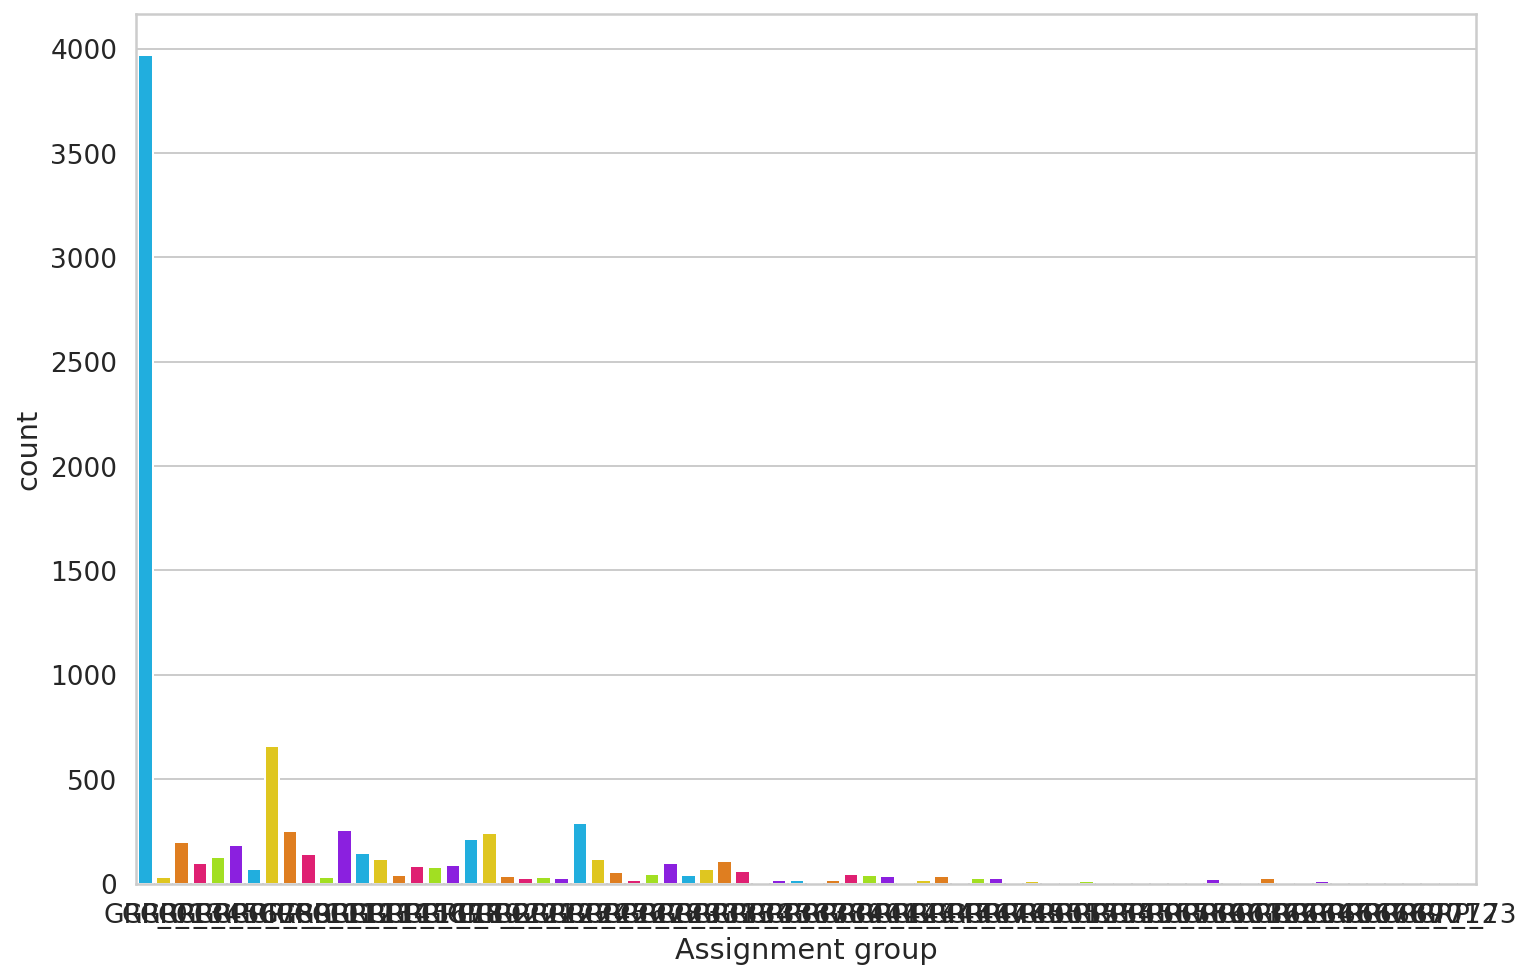

In [11]:
chart = sns.countplot(incidents['Assignment group'], palette=HAPPY_COLORS_PALETTE)

In [12]:
inc_clus = pd.DataFrame(incidents['Assignment group'].unique(),columns=['Assignment group'])
for i in incidents['Assignment group'].unique():
  inc_clus.loc[inc_clus['Assignment group']==i,'embedding'] = pd.Series([np.mean(incidents[incidents['Assignment group']==i]['embedding'])],
                                                                        index=inc_clus.loc[inc_clus['Assignment group']==i].index,dtype='object')
  inc_clus.loc[inc_clus['Assignment group']==i,'frequency'] = pd.Series(incidents[incidents['Assignment group']==i].shape[0],
                                                                        index=inc_clus.loc[inc_clus['Assignment group']==i].index,dtype='object')
  
model = AgglomerativeClustering(n_clusters=45, affinity='euclidean',  linkage='average')
model.fit(inc_clus['embedding'].values.tolist())
inc_clus['class'] = model.labels_

In [13]:
clus_arrngmt = pd.DataFrame([(i,inc_clus[inc_clus['class']==i]['Assignment group'].values) for i in inc_clus['class'].unique()],columns=['cluster id','cluster groups'])
clus_arrngmt.set_index('cluster id',inplace=True)
clus_arrngmt['ticket_counts'] = incidents['class'].value_counts()
clus_arrngmt['class_counts'] = inc_clus['class'].value_counts()
clus_arrngmt.reset_index(inplace=True)
clus_arrngmt.sort_values(by='ticket_counts',ascending=False,inplace=True)
clus_arrngmt=clus_arrngmt[clus_arrngmt['ticket_counts']>100]
clus_arrngmt.sum()

cluster id        117
ticket_counts    7944
class_counts       38
dtype: int64

In [14]:
clus_arrngmt

,cluster id,cluster groups,ticket_counts,class_counts
0,20,"[GRP_0, GRP_3, GRP_19, GRP_25, GRP_51, GRP_59]",4513,6
2,0,"[GRP_4, GRP_12, GRP_13, GRP_15, GRP_18, GRP_2, GRP_29, GRP_53, GRP_65]",989,9
5,33,[GRP_8],661,1
3,18,"[GRP_5, GRP_6, GRP_9]",565,3
12,27,[GRP_24],289,1
7,2,"[GRP_11, GRP_14, GRP_20, GRP_41, GRP_62]",249,5
8,1,"[GRP_16, GRP_22, GRP_26, GRP_40]",217,4
6,3,"[GRP_10, GRP_44, GRP_45]",190,3
17,9,"[GRP_33, GRP_42, GRP_49]",150,3
14,4,"[GRP_28, GRP_34, GRP_37]",121,3


Current clustering setup is the result of comparison of average of glove word embeddings. As we can see below, it has the class imbalance still.

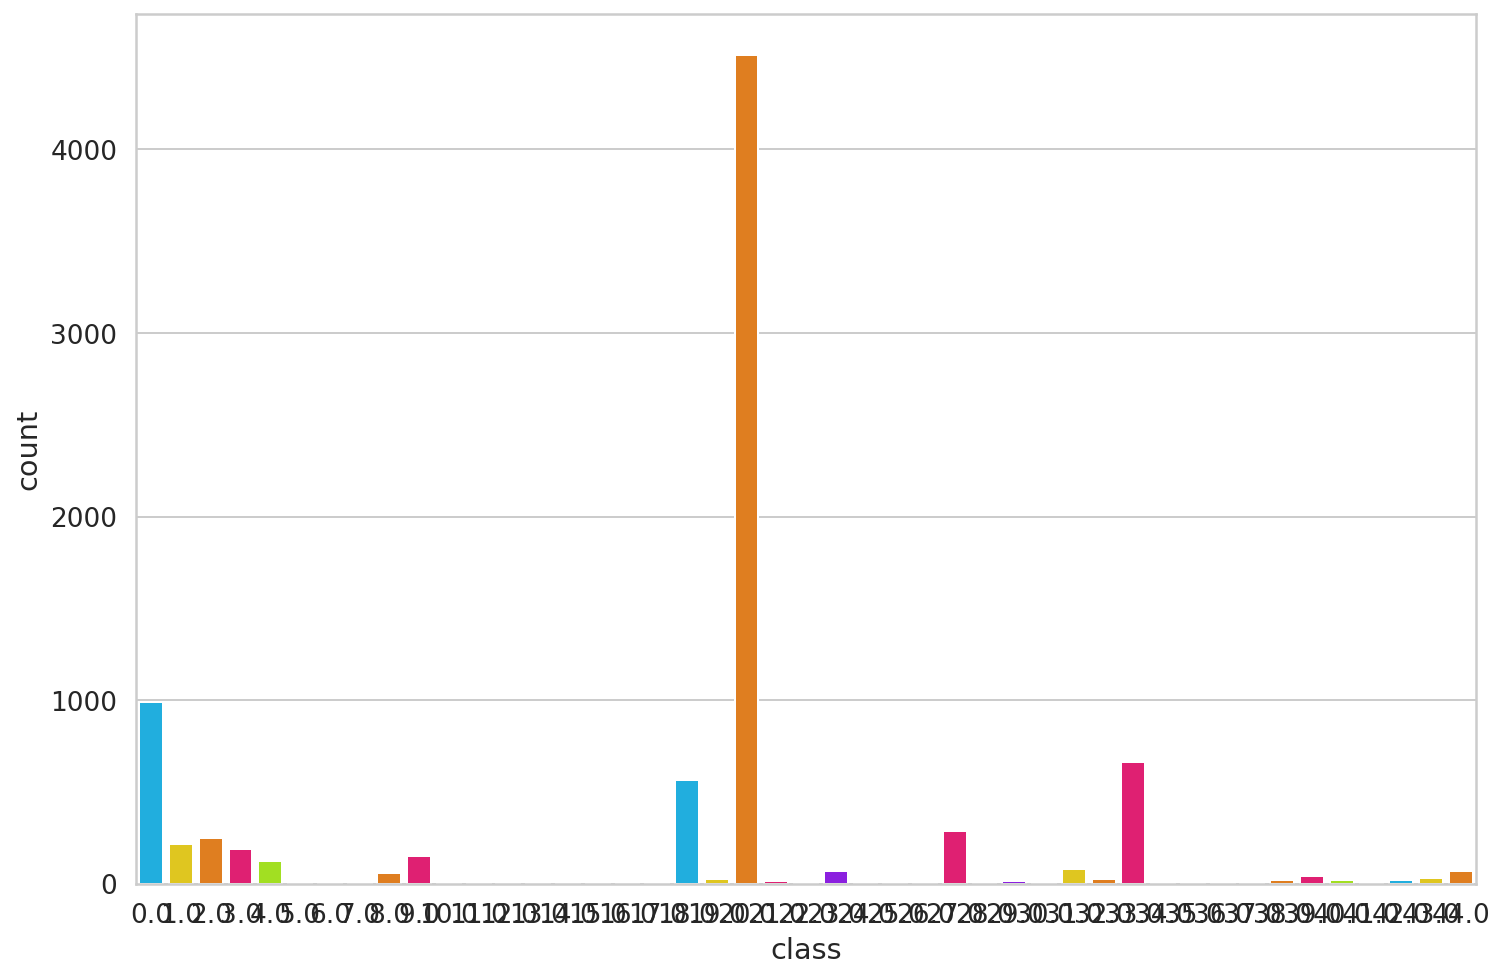

In [15]:
chart = sns.countplot(incidents['class'], palette=HAPPY_COLORS_PALETTE)

Let us try a method to reduce records of most frequent classes.

Jaccard similarity is a raw method of determing similarity between sentences. It only considers the lexical representation and ignores the semantic representation. In simpler terms, it will look for common words but doesn't consider synonyms since it doesn't understand the meaning of words.

In [16]:
def jaccard_similarity(query, document):
    intersection = set(query).intersection(set(document))
    union = set(query).union(set(document))
    return len(intersection)/len(union)

In [17]:
## Sample
sent1= "AI is our friend and it has been friendly"
sent2= "AI and humans have always been friendly"
jaccard_similarity(sent1,sent2)

0.7619047619047619

Let us try a different type of comparison. Instead of tokens, let us use the embeddings and distance metrics such as cosine similarity.

In [18]:
!wget https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip

--2020-08-28 02:31:24--  https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.128, 74.125.203.128, 64.233.189.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 407727028 (389M) [application/zip]
Saving to: ‘uncased_L-12_H-768_A-12.zip.8’

uncased_L-12_H-768_ 100%[===================>] 388.84M  58.9MB/s    in 10s     

2020-08-28 02:31:34 (37.8 MB/s) - ‘uncased_L-12_H-768_A-12.zip.8’ saved [407727028/407727028]



In [19]:
!unzip uncased_L-12_H-768_A-12.zip

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [20]:
os.makedirs('model', exist_ok=True)

In [21]:
!mv uncased_L-12_H-768_A-12/ model

In [22]:
bert_model_name = 'uncased_L-12_H-768_A-12'
bert_ckpt_dir = os.path.join('model/',bert_model_name)
bert_ckpt_file = os.path.join(bert_ckpt_dir, 'bert_model.ckpt')
bert_config_file = os.path.join(bert_ckpt_dir, 'bert_config.json')

In [23]:
bert_ckpt_file

'model/uncased_L-12_H-768_A-12/bert_model.ckpt'

In [24]:
inc_bert = incidents[['tokens','Assignment group']]
inc_bert.head(2)

,tokens,Assignment group
0,login issue verify user detail employee manager name check user name ad reset password advise user login check caller confirm able login issue resolve,GRP_0
1,receive hmjdrvpb komuaywn gmail com hello team meeting skype meeting etc appear outlook calendar somebody please advise correct kind,GRP_0


In [25]:
tokenizer = FullTokenizer(vocab_file = os.path.join(bert_ckpt_dir, 'vocab.txt'))
tokens = tokenizer.tokenize("hello guys, my first project is great!")
tokenizer.convert_tokens_to_ids(tokens)

[7592, 4364, 1010, 2026, 2034, 2622, 2003, 2307, 999]

In [26]:
max_len_param = 300
max_seq_len = 0

x = []
for i in inc_bert['tokens']:
  tokens = tokenizer.tokenize(i)
  tokens = ["[CLS]"] + tokens + ["[SEP]"]
  token_ids = tokenizer.convert_tokens_to_ids(tokens)
  max_seq_len = max(max_seq_len, len(token_ids))
  x.append(token_ids)

ids = np.array(x)
max_seq_len = min(max_seq_len, max_len_param)

x = []
for i in ids:
  cut_point = min(len(i), max_seq_len - 2)
  i = i[:cut_point]
  i = i + [0] * (max_seq_len - len(i))
  x.append(np.array(i))

embedding = np.array(x)


In [27]:
inc_bert['embeds'] = embedding.tolist()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [28]:
inc_bert.head()

,tokens,Assignment group,embeds
0,login issue verify user detail employee manager name check user name ad reset password advise user login check caller confirm able login issue resolve,GRP_0,"[101, 8833, 2378, 3277, 20410, 5310, 6987, 7904, 3208, 2171, 4638, 5310, 2171, 4748, 25141, 20786, 18012, 5310, 8833, 2378, 4638, 20587, 12210, 2583, 8833, 2378, 3277, 10663, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
1,receive hmjdrvpb komuaywn gmail com hello team meeting skype meeting etc appear outlook calendar somebody please advise correct kind,GRP_0,"[101, 4374, 20287, 3501, 13626, 2615, 2361, 2497, 12849, 12274, 4710, 7962, 20917, 4014, 4012, 7592, 2136, 3116, 3712, 5051, 3116, 4385, 3711, 17680, 8094, 8307, 3531, 18012, 6149, 2785, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
2,log vpn receive eylqgodm ybqkwiam gmail com hi log vpn best,GRP_0,"[101, 8833, 21210, 2078, 4374, 1041, 8516, 4160, 3995, 22117, 1061, 2497, 4160, 2243, 9148, 3286, 20917, 4014, 4012, 7632, 8833, 21210, 2078, 2190, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
3,unable access hr_tool page,GRP_0,"[101, 4039, 3229, 17850, 1035, 6994, 3931, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"
4,skype error,GRP_0,"[101, 3712, 5051, 7561, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]"


Since group 0 constitutes half of the records, let us handle them separately.

In [29]:
inc_grp0 = inc_bert[inc_bert['Assignment group']=='GRP_0']
inc_bert = inc_bert[inc_bert['Assignment group']!='GRP_0']

In [30]:
print(inc_bert.shape)
print(inc_grp0.shape)

(4523, 3)
(3968, 3)


In [31]:
inc_grp0.reset_index(drop=True,inplace=True)
inc_grp0.index

RangeIndex(start=0, stop=3968, step=1)

Since we have collected embeddings, we can use comparison techniques. Let us try cosine distance in comparison to jaccard similarity illustrated on top already.

In [32]:
#Let us consider preprocessed sentences for comparison
sent1= "AI is our friend and it has been friend"
sent2= "AI and humans has always been friend"
sent3= "Obama speaks media Illinois"
sent4= "president greets press Chicago"

In [34]:
import scipy
import random

print('Similarity between sentences 1 and 2:-')
print('cosine metric:',1 - scipy.spatial.distance.cosine(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sent1)),tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sent2))+[0]*2))
print('Jaccard similarity:',jaccard_similarity(sent1,sent2))

print('Similarity between sentences 3 and 4:-')
print('cosine metric:',1 - scipy.spatial.distance.cosine(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sent3))+[0]*1,tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sent4))))
print('Jaccard similarity:',jaccard_similarity(sent3,sent4))

Similarity between sentences 1 and 2:-
cosine metric: 0.9390806637650261
Jaccard similarity: 0.7
Similarity between sentences 3 and 4:-
cosine metric: 0.8051660033160822
Jaccard similarity: 0.42857142857142855


We could see that Jaccard identifies the first 2 sentences as similar successfully, but failed in the next 2 sentences because there is no lexical match though semantically similar.

In [35]:

for i in range(100000):  #randomly choosing 100k iterations of comparison
  a=random.randint(0,inc_grp0.shape[0]-1)
  b=random.randint(0,inc_grp0.shape[0]-1)
  if (a!=b):
    if ((1-scipy.spatial.distance.cosine(inc_grp0.iloc[a]['embeds'],inc_grp0.iloc[b]['embeds'])) > 0.6):
      inc_grp0.drop(b, inplace=True)
      inc_grp0.reset_index(drop=True, inplace=True)


In [36]:
print(inc_grp0.shape)

(307, 3)


We have reduced number of records for GRP_0 from 3968 to around 250 and also they must be covering records which are more dissimilar and specific in nature.

In [37]:
inc_bert = pd.concat([inc_grp0, inc_bert])
print(inc_bert.shape)

(4830, 3)


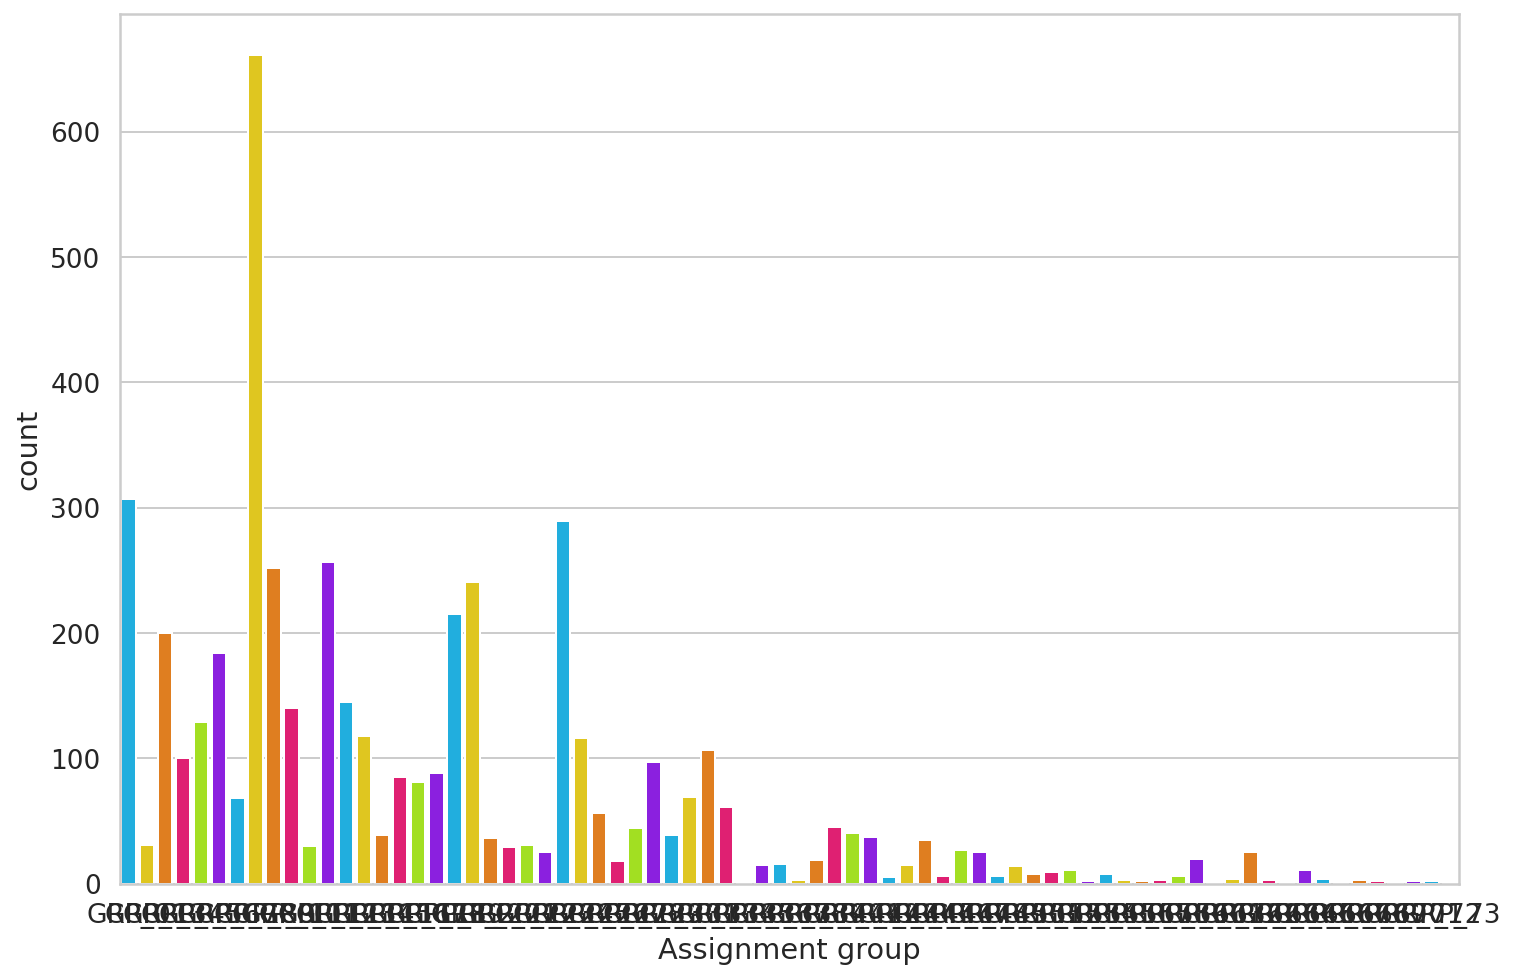

In [38]:
chart = sns.countplot(inc_bert['Assignment group'], palette=HAPPY_COLORS_PALETTE)

In [39]:
inc_clus = pd.DataFrame(inc_bert['Assignment group'].unique(),columns=['Assignment group'])
for i in inc_bert['Assignment group'].unique():
  inc_clus.loc[inc_clus['Assignment group']==i,'embeds'] = pd.Series([np.mean(inc_bert[inc_bert['Assignment group']==i]['embeds'].tolist(),axis=0)],
                                                                        index=inc_clus.loc[inc_clus['Assignment group']==i].index,dtype='object')
  inc_clus.loc[inc_clus['Assignment group']==i,'frequency'] = pd.Series(inc_bert[inc_bert['Assignment group']==i].shape[0],
                                                                        index=inc_clus.loc[inc_clus['Assignment group']==i].index,dtype='object')
  

In [40]:
inc_clus.head()

,Assignment group,embeds,frequency
0,GRP_0,"[101.0, 7901.807817589576, 7331.280130293159, 7583.794788273615, 7401.231270358307, 6903.869706840391, 7114.299674267101, 7157.7557003257325, 6917.055374592834, 7260.065146579805, 7385.742671009772, 7588.068403908795, 7438.459283387622, 7931.267100977198, 6567.2540716612375, 6924.156351791531, 7438.729641693811, 7158.990228013029, 6581.801302931596, 7654.514657980456, 6380.019543973941, 6423.586319218241, 6293.671009771987, 6177.895765472313, 6282.348534201954, 6721.511400651466, 6222.882736156352, 6437.221498371336, 6166.0814332247555, 6343.28338762215, 6501.85342019544, 5535.771986970684, 6227.061889250815, 6426.99348534202, 5996.100977198697, 6295.0749185667755, 6560.840390879479, 6082.182410423453, 6180.723127035831, 6186.4169381107495, 5790.332247557003, 6446.459283387622, 6068.99348534202, 6132.332247557003, 5858.192182410424, 6296.228013029316, 5131.100977198697, 5872.71335504886, 6049.257328990228, 5296.107491856677, 5455.697068403909, 6527.768729641693, 5860.876221498372, 5600.214983713355, 6198.534201954398, 5164.456026058632, 5271.482084690554, 5518.882736156352, 4816.863192182411, 4744.241042345277, 4905.42996742671, 4723.599348534202, 4467.657980456026, 4617.179153094463, 4268.381107491857, 4197.85016286645, 4733.413680781759, 4256.628664495114, 5199.827361563518, 4243.758957654723, 4239.055374592834, 3916.267100977199, 4466.407166123779, 4360.732899022802, 4750.377850162867, 3882.485342019544, 3932.5895765472314, 3423.7068403908793, 3398.9348534201954, 3903.403908794788, 3779.7752442996743, 3867.0423452768728, 3222.511400651466, 3481.1042345276874, 3588.4364820846904, 2967.885993485342, 3561.228013029316, 3148.241042345277, 3251.355048859935, 2766.3387622149835, 3283.1237785016287, 3074.4918566775245, 2860.885993485342, 2288.7068403908793, 2888.413680781759, 3000.869706840391, 2626.8762214983713, 2614.5798045602605, 2659.840390879479, 2739.3843648208467, ...]",307
1,GRP_1,"[101.0, 6933.0, 11129.032258064517, 3317.7741935483873, 9772.483870967742, 7855.322580645161, 7369.677419354839, 7300.193548387097, 7864.870967741936, 4441.193548387097, 5333.225806451613, 5383.225806451613, 6993.580645161291, 6579.8387096774195, 5615.225806451613, 6557.774193548387, 5571.225806451613, 5532.806451612903, 6225.290322580645, 6900.612903225807, 6481.064516129032, 7549.322580645161, 5651.806451612903, 5509.935483870968, 6989.774193548387, 6440.8387096774195, 5836.290322580645, 4024.451612903226, 7100.096774193548, 4912.032258064516, 4937.451612903225, 4519.1612903225805, 5495.096774193548, 5043.354838709677, 2421.516129032258, 3632.7096774193546, 3441.1290322580644, 2113.451612903226, 4826.645161290323, 3393.967741935484, 3590.967741935484, 2287.2580645161293, 4149.258064516129, 3407.6451612903224, 3045.8387096774195, 2735.2903225806454, 1853.483870967742, 1788.0967741935483, 1801.3225806451612, 3305.3548387096776, 967.1290322580645, 3275.1612903225805, 2331.451612903226, 1842.5806451612902, 3631.548387096774, 2318.7096774193546, 927.7741935483871, 1750.3548387096773, 3289.6774193548385, 1916.7096774193549, 2873.5806451612902, 808.741935483871, 2367.064516129032, 1368.032258064516, 2279.064516129032, 865.0322580645161, 690.0322580645161, 1624.1612903225807, 1330.516129032258, 1955.4193548387098, 1637.3548387096773, 912.0967741935484, 2385.6451612903224, 1569.5483870967741, 519.5806451612904, 1297.516129032258, 1171.4193548387098, 2179.8064516129034, 1325.4193548387098, 2357.7741935483873, 1159.5806451612902, 1368.2903225806451, 1697.1612903225807, 1223.0645161290322, 1650.1290322580646, 1846.6129032258063, 819.258064516129, 1088.8387096774193, 1237.8709677419354, 1623.3548387096773, 181.58064516129033, 550.9032258064516, 178.25806451612902, 201.67741935483872, 680.5806451612904, 207.09677419354838, 1085.5806451612902, 218.32258064516128, 856.1935483870968, 338.4516129032258, ...]",31
2,GRP_3,"[101.0, 8293.315, 7463.475, 7370.23, 6537.085, 6581.49, 6716.8, 5813.205, 6472.03, 5658.53, 4688.

In [41]:
model = AgglomerativeClustering(n_clusters=5, affinity='euclidean',  linkage='average')
model.fit(inc_clus['embeds'].values.tolist())
#inc_clus['class'] = model.labels_

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='average', memory=None, n_clusters=5)

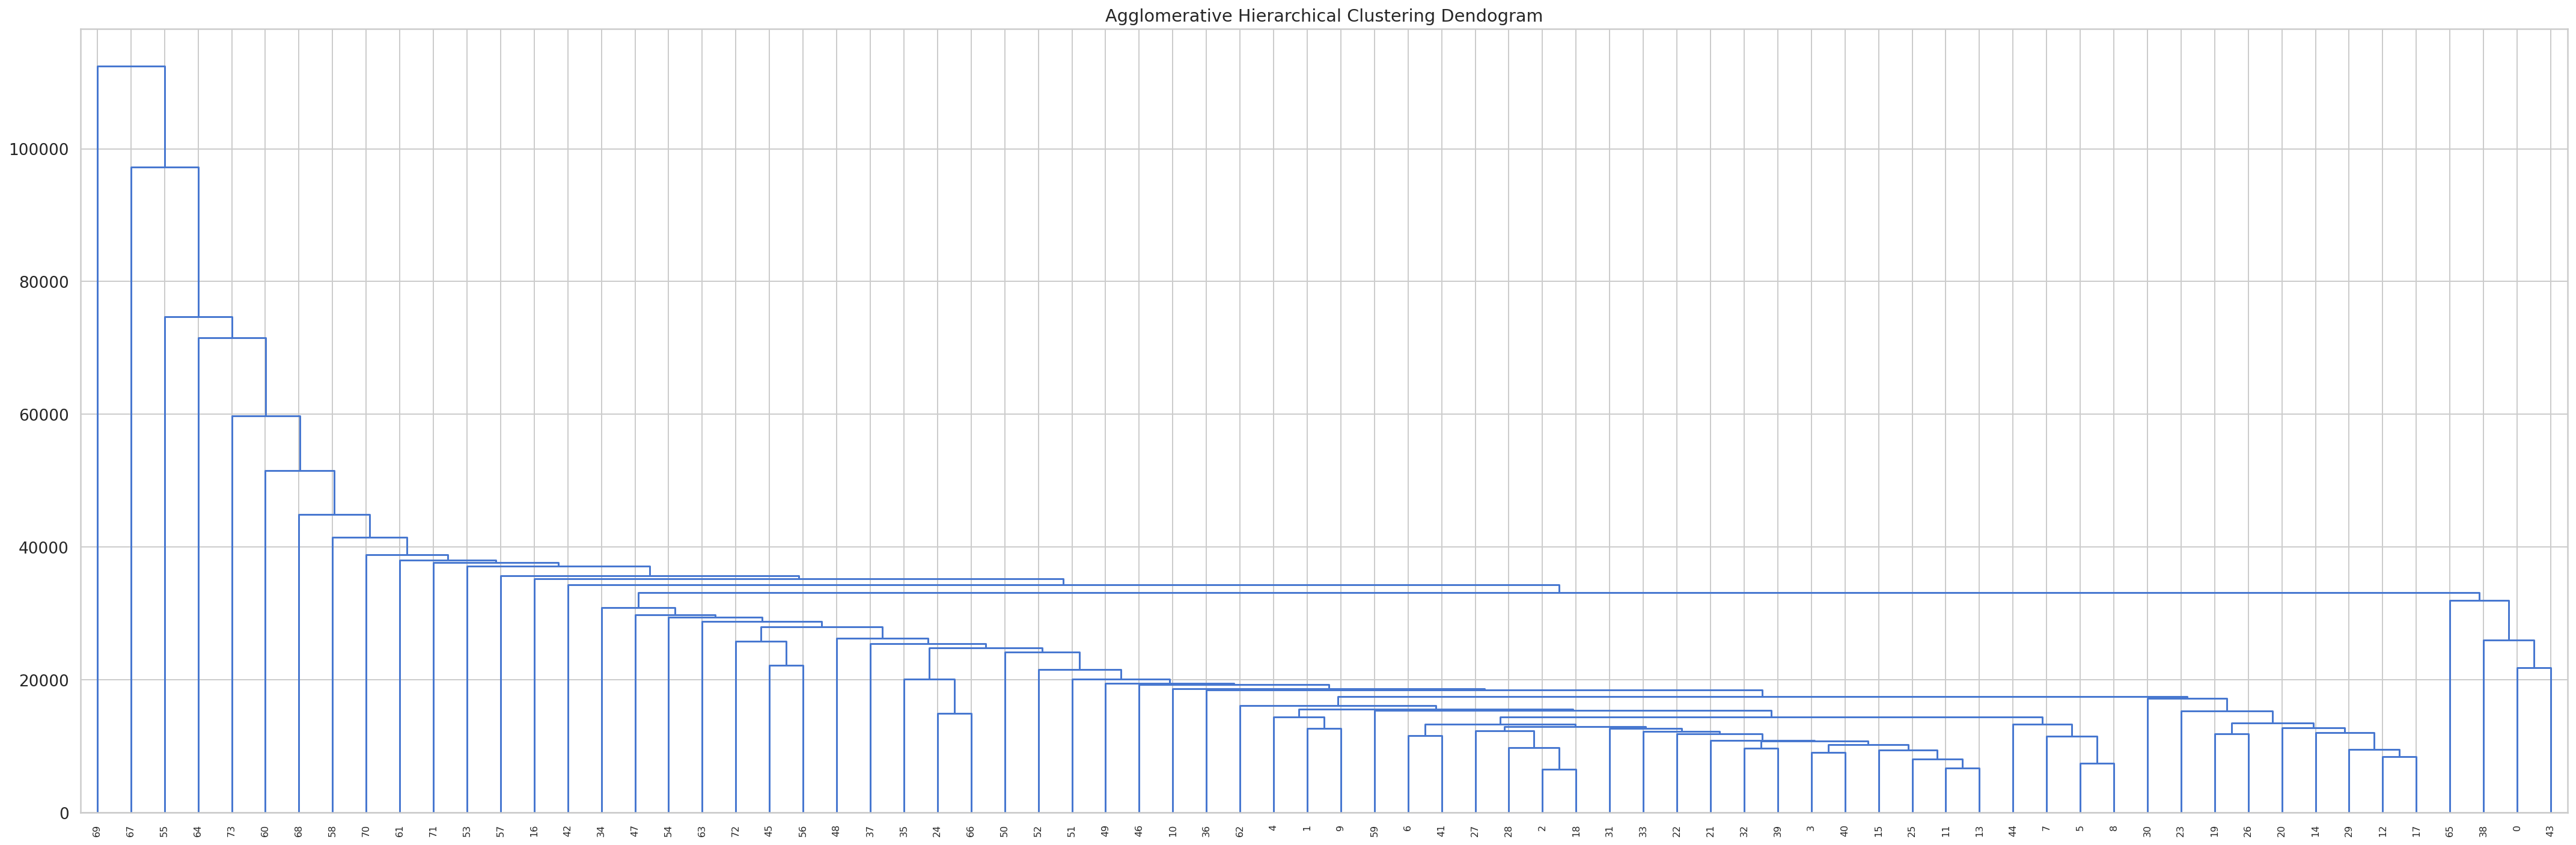

In [42]:
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage

plt.figure(figsize=(30, 10))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
Z = linkage(inc_clus['embeds'].values.tolist(), metric='euclidean', method='average')
dendrogram(Z, leaf_rotation=90, color_threshold=40, leaf_font_size=8)
plt.tight_layout()

In [43]:
inc_bert['Assignment group'].value_counts()

GRP_8     661
GRP_0     307
GRP_24    289
GRP_12    257
GRP_9     252
         ... 
GRP_73      1
GRP_70      1
GRP_35      1
GRP_67      1
GRP_61      1
Name: Assignment group, Length: 74, dtype: int64

In [44]:
model = AgglomerativeClustering(n_clusters=30, affinity='euclidean',  linkage='average')
model.fit(inc_clus['embeds'].values.tolist())
inc_clus['class'] = model.labels_
inc_clus['class'].value_counts()

1     42
2      3
0      2
28     1
3      1
4      1
5      1
6      1
7      1
8      1
9      1
10     1
11     1
12     1
13     1
29     1
15     1
16     1
17     1
18     1
19     1
20     1
21     1
22     1
23     1
24     1
25     1
26     1
27     1
14     1
Name: class, dtype: int64

In [48]:
for i in inc_bert['Assignment group'].unique():
  inc_bert.loc[inc_bert['Assignment group']==i,'class'] = inc_clus[inc_clus['Assignment group']==i]['class'].values[0]

In [49]:
inc_bert['class'].value_counts()

1.0     3990
0.0      322
2.0      308
29.0      81
19.0      25
24.0      19
8.0       11
28.0       8
20.0       8
23.0       6
14.0       6
17.0       6
15.0       5
21.0       4
7.0        3
10.0       3
16.0       3
26.0       3
27.0       3
22.0       2
4.0        2
12.0       2
5.0        2
25.0       2
11.0       1
13.0       1
3.0        1
6.0        1
18.0       1
9.0        1
Name: class, dtype: int64

As we can see above, the class imbalance is more prominent after using bert embeddings. In other words, Bert is able to distinctly understand the characteristic of each group.

In [50]:
clus_arrngmt = pd.DataFrame([(i,inc_clus[inc_clus['class']==i]['Assignment group'].values) for i in inc_clus['class'].unique()],columns=['cluster id','cluster groups'])
clus_arrngmt.set_index('cluster id',inplace=True)
clus_arrngmt['ticket_counts'] = inc_bert['class'].value_counts()
clus_arrngmt['class_counts'] = inc_clus['class'].value_counts()
clus_arrngmt.reset_index(inplace=True)
clus_arrngmt.sort_values(by='ticket_counts',ascending=False,inplace=True)
clus_arrngmt=clus_arrngmt[clus_arrngmt['ticket_counts']>100]
clus_arrngmt.sum()

cluster id          3
ticket_counts    4620
class_counts       47
dtype: int64

In [51]:
clus_arrngmt

,cluster id,cluster groups,ticket_counts,class_counts
1,1,"[GRP_1, GRP_3, GRP_4, GRP_5, GRP_6, GRP_7, GRP_8, GRP_9, GRP_10, GRP_11, GRP_12, GRP_13, GRP_14, GRP_15, GRP_16, GRP_18, GRP_19, GRP_2, GRP_20, GRP_21, GRP_22, GRP_23, GRP_25, GRP_26, GRP_27, GRP_28, GRP_29, GRP_30, GRP_31, GRP_33, GRP_34, GRP_37, GRP_40, GRP_41, GRP_42, GRP_45, GRP_47, GRP_50, GRP_52, GRP_53, GRP_60, GRP_62]",3990,42
0,0,"[GRP_0, GRP_44]",322,2
3,2,"[GRP_24, GRP_36, GRP_66]",308,3


PREDICTION USING GLOVE EMBEDDINGS

In [63]:
inc_clus = pd.DataFrame(incidents['Assignment group'].unique(),columns=['Assignment group'])

for i in incidents['Assignment group'].unique():
  inc_clus.loc[inc_clus['Assignment group']==i,'embedding'] = pd.Series([np.mean(incidents[incidents['Assignment group']==i]['embedding'])],
                                                                        index=inc_clus.loc[inc_clus['Assignment group']==i].index,dtype='object')
  inc_clus.loc[inc_clus['Assignment group']==i,'frequency'] = pd.Series(incidents[incidents['Assignment group']==i].shape[0],
                                                                        index=inc_clus.loc[inc_clus['Assignment group']==i].index,dtype='object')

In [64]:
#Agglomerative Clustering
model = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='average')
model.fit(inc_clus['embedding'].values.tolist())

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='average', memory=None, n_clusters=5)

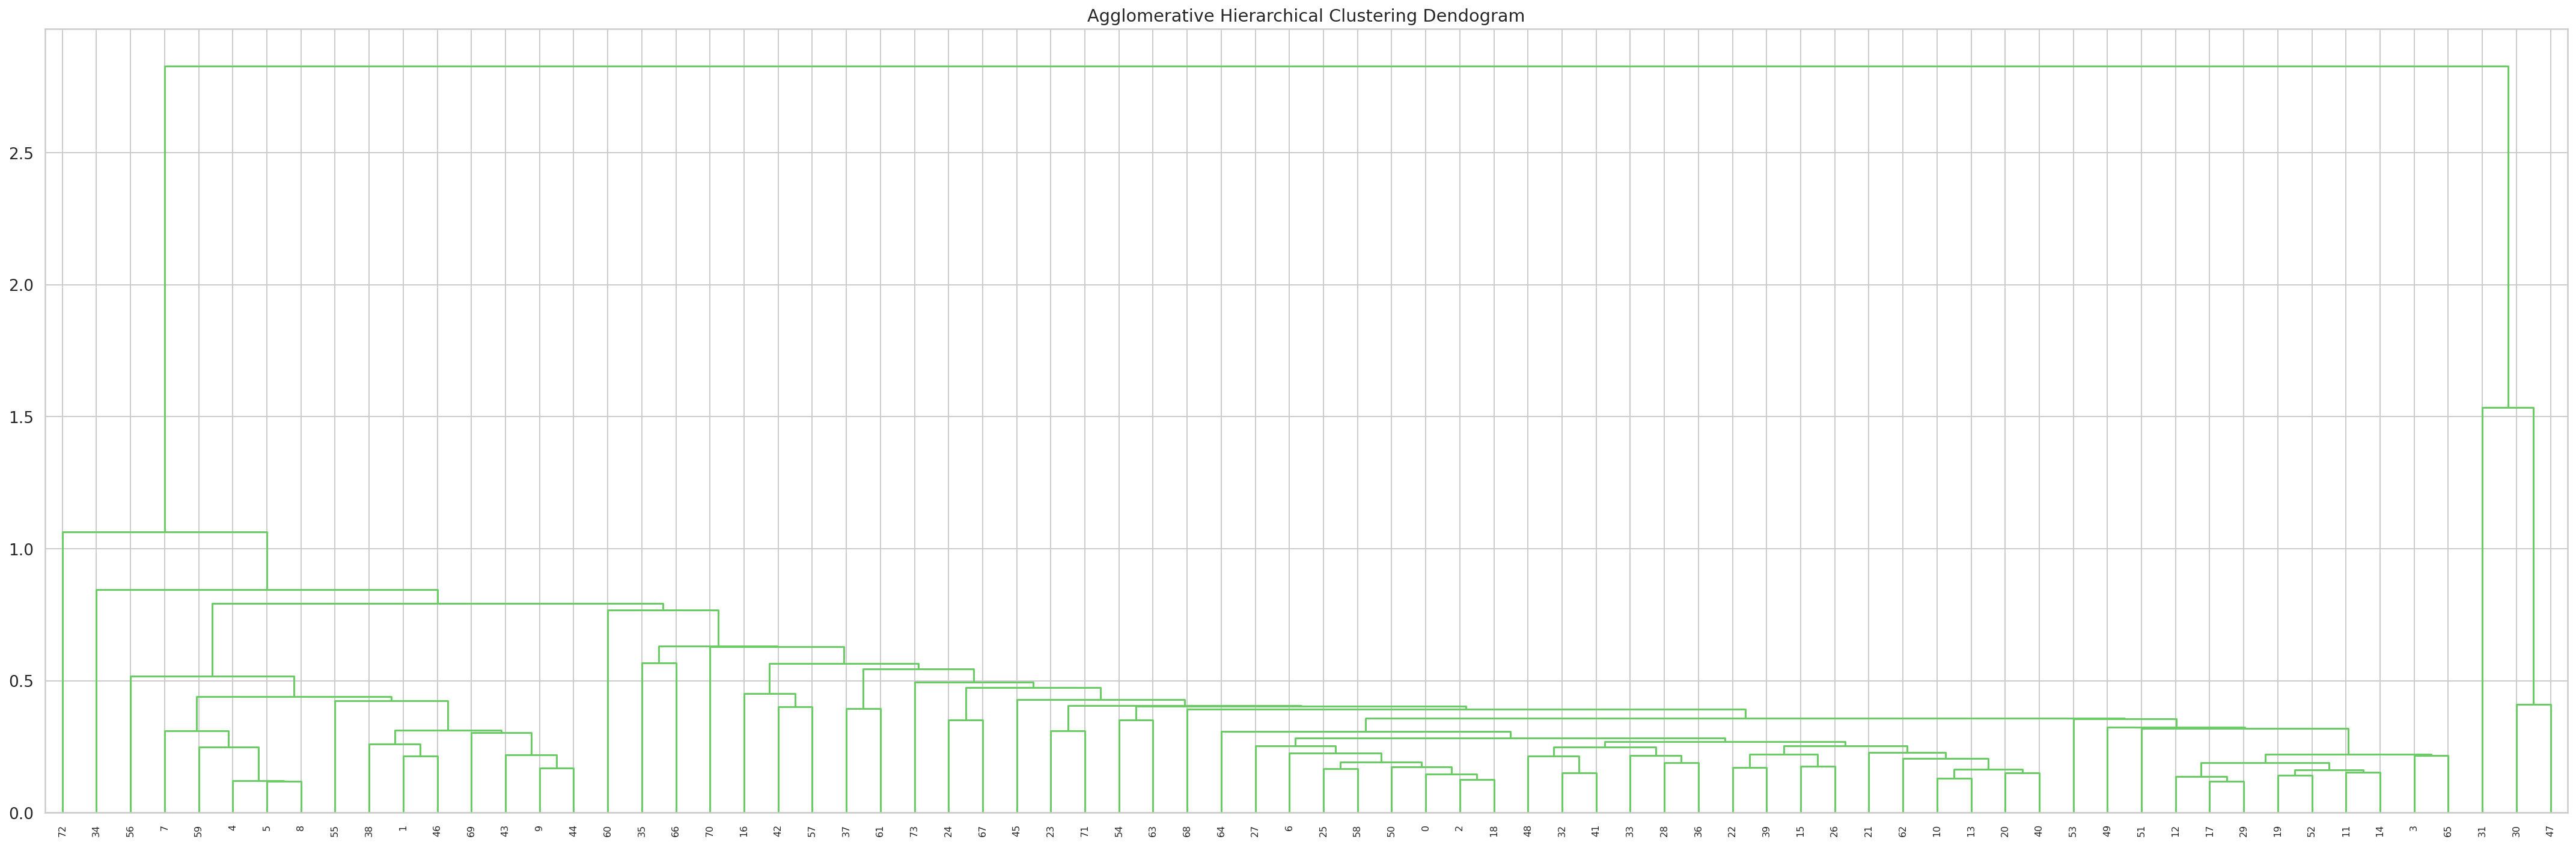

In [65]:
plt.figure(figsize=(30, 10))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
Z = linkage(inc_clus['embedding'].values.tolist(), metric='euclidean', method='average')
dendrogram(Z, leaf_rotation=90, color_threshold=40, leaf_font_size=8)
plt.tight_layout()

**Observation:**

From the above graph, records for specific groups are largely different from most other groups which seem to be similar. The motive behind performing clustering is to counter the class imbalance in our data. When we choose to form clusters, it needs to satisfy the below condition:
* The clusters must restore some class balance in our data so that our classification model can predict precisely
* The clusters must not be a combination of large number of assignment groups each, if so then we will not be able to infer properly from the classification

Going by this logic, we go with 45 clusters

In [66]:
model = AgglomerativeClustering(n_clusters=45, affinity='euclidean',  linkage='average')
model.fit(inc_clus['embedding'].values.tolist())

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='average', memory=None, n_clusters=45)

In [67]:
inc_clus['class'] = model.labels_
inc_clus['class'].value_counts()

0     9
20    6
2     5
1     4
3     3
4     3
18    3
9     3
8     2
14    1
19    1
17    1
16    1
15    1
11    1
13    1
12    1
21    1
7     1
6     1
5     1
10    1
44    1
43    1
23    1
42    1
41    1
40    1
39    1
38    1
37    1
36    1
35    1
34    1
33    1
32    1
31    1
30    1
29    1
28    1
27    1
26    1
25    1
24    1
22    1
Name: class, dtype: int64

We can see that most of the clusters have only one group each. This is not an ideal scenario since then there are lot of labels to classify.

In [68]:
for i in incidents['Assignment group'].unique():
  incidents.loc[incidents['Assignment group']==i,'class'] = inc_clus[inc_clus['Assignment group']==i]['class'].values[0]

In [69]:
clus_arrngmt = pd.DataFrame([(i,inc_clus[inc_clus['class']==i]['Assignment group'].values) for i in inc_clus['class'].unique()],columns=['cluster id','cluster groups'])
clus_arrngmt.set_index('cluster id',inplace=True)
clus_arrngmt['ticket_counts'] = incidents['class'].value_counts()
clus_arrngmt['class_counts'] = inc_clus['class'].value_counts()
clus_arrngmt.reset_index(inplace=True)
clus_arrngmt.head()

,cluster id,cluster groups,ticket_counts,class_counts
0,20,"[GRP_0, GRP_3, GRP_19, GRP_25, GRP_51, GRP_59]",4513,6
1,8,"[GRP_1, GRP_47]",58,2
2,0,"[GRP_4, GRP_12, GRP_13, GRP_15, GRP_18, GRP_2, GRP_29, GRP_53, GRP_65]",989,9
3,18,"[GRP_5, GRP_6, GRP_9]",565,3
4,44,[GRP_7],68,1


In [70]:
clus_arrngmt.sort_values(by='ticket_counts',ascending=False,inplace=True)
clus_arrngmt=clus_arrngmt[clus_arrngmt['ticket_counts']>100]
clus_arrngmt.sum()

cluster id        117
ticket_counts    7944
class_counts       38
dtype: int64

**Observation:**

We have tried to counter the challenges by filtering those clusters which are associated with at least 100 records. We have arrived at 10 clusters, the class balance has been improved slightly.

In [71]:
clus_arrngmt

,cluster id,cluster groups,ticket_counts,class_counts
0,20,"[GRP_0, GRP_3, GRP_19, GRP_25, GRP_51, GRP_59]",4513,6
2,0,"[GRP_4, GRP_12, GRP_13, GRP_15, GRP_18, GRP_2, GRP_29, GRP_53, GRP_65]",989,9
5,33,[GRP_8],661,1
3,18,"[GRP_5, GRP_6, GRP_9]",565,3
12,27,[GRP_24],289,1
7,2,"[GRP_11, GRP_14, GRP_20, GRP_41, GRP_62]",249,5
8,1,"[GRP_16, GRP_22, GRP_26, GRP_40]",217,4
6,3,"[GRP_10, GRP_44, GRP_45]",190,3
17,9,"[GRP_33, GRP_42, GRP_49]",150,3
14,4,"[GRP_28, GRP_34, GRP_37]",121,3


In [72]:
incidents_clust = incidents[incidents['class'].isin(clus_arrngmt['cluster id'].values)]
incidents_clust.shape

(7944, 9)

In [73]:
class TicketAssgnData:
  DATA_COLUMN = 'tokens'
  LABEL_COLUMN = 'class'

  def __init__(self, train, test, tokenizer: FullTokenizer, classes, max_seq_len=350):
    self.tokenizer = tokenizer
    self.max_seq_len = 0
    self.classes = classes

    ((self.train_x, self.train_y), (self.test_x, self.test_y)) = map(self._prepare, [train, test])

    self.max_seq_len = min(self.max_seq_len, max_seq_len)
    self.train_x, self.test_x = map(self._pad, [self.train_x, self.test_x])

  def _prepare(self, df):
    x, y = [], []

    for _, row in tqdm(df.iterrows()):
      text, label = row[TicketAssgnData.DATA_COLUMN], row[TicketAssgnData.LABEL_COLUMN]
      tokens = self.tokenizer.tokenize(text)
      tokens = ["[CLS]"] + tokens + ["[SEP]"]
      token_ids = self.tokenizer.convert_tokens_to_ids(tokens)
      self.max_seq_len = max(self.max_seq_len, len(token_ids))
      
      x.append(token_ids)
      y.append(self.classes.index(label))
    return np.array(x), np.array(y)

  def _pad(self, ids):
    x= []
    for input_ids in ids:
      cut_point = min(len(input_ids), self.max_seq_len - 2)
      input_ids = input_ids[:cut_point]
      
      input_ids = input_ids + [0] * (self.max_seq_len - len(input_ids))
      x.append(np.array(input_ids))
    return np.array(x)


In [74]:
tokenizer = FullTokenizer(vocab_file = os.path.join(bert_ckpt_dir, 'vocab.txt'))

In [75]:
def create_model(max_seq_len, bert_config_file, bert_ckpt_file):

  with tf.io.gfile.GFile(bert_config_file, 'r') as reader:
    bc = StockBertConfig.from_json_string(reader.read())
    bert_params = map_stock_config_to_params(bc)
    bert_params.adapter_size = None
    bert = BertModelLayer.from_params(bert_params, name='bert')

  input_ids = keras.layers.Input(shape=(max_seq_len,),dtype='int32',name='input_ids')
  bert_output = bert(input_ids)

  print('bert shape', bert_output.shape)
 
  cls_out = keras.layers.Lambda(lambda seq: seq[:, 0, :])(bert_output)
  cls_out = keras.layers.Dropout(0.5)(cls_out)
  logits = keras.layers.Dense(units=768, activation='tanh')(cls_out)
  logits = keras.layers.Dropout(0.5)(logits)
  logits = keras.layers.Dense(units=len(classes), activation='softmax')(logits)

  model = keras.Model(inputs=input_ids, outputs=logits)
  model.build(input_shape=(None, max_seq_len))

  load_stock_weights(bert, bert_ckpt_file)

  return model


In [77]:
from sklearn.model_selection import train_test_split
#Prediction using glove embeddings
train, test = train_test_split(incidents_clust[['tokens','class']], test_size=0.25, random_state=10)

train.reset_index(drop=True,inplace=True)
test.reset_index(drop=True,inplace=True)

In [78]:
classes = train['class'].unique().tolist()

data = TicketAssgnData(train, test, tokenizer, classes, max_seq_len=350)

5958it [00:04, 1421.88it/s]
1986it [00:01, 1291.01it/s]


In [79]:
model = create_model(data.max_seq_len, bert_config_file, bert_ckpt_file)

bert shape (None, 350, 768)
Done loading 196 BERT weights from: model/uncased_L-12_H-768_A-12/bert_model.ckpt into <bert.model.BertModelLayer object at 0x7f8b5ad849b0> (prefix:bert). Count of weights not found in the checkpoint was: [0]. Count of weights with mismatched shape: [0]
Unused weights from checkpoint: 
	bert/embeddings/token_type_embeddings
	bert/pooler/dense/bias
	bert/pooler/dense/kernel
	cls/predictions/output_bias
	cls/predictions/transform/LayerNorm/beta
	cls/predictions/transform/LayerNorm/gamma
	cls/predictions/transform/dense/bias
	cls/predictions/transform/dense/kernel
	cls/seq_relationship/output_bias
	cls/seq_relationship/output_weights


In [81]:
data.train_x.shape

(5958, 350)

In [82]:
data.train_y[10]

1

In [83]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_ids (InputLayer)       [(None, 350)]             0         
_________________________________________________________________
bert (BertModelLayer)        (None, 350, 768)          108890112 
_________________________________________________________________
lambda (Lambda)              (None, 768)               0         
_________________________________________________________________
dropout (Dropout)            (None, 768)               0         
_________________________________________________________________
dense (Dense)                (None, 768)               590592    
_________________________________________________________________
dropout_1 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)               

In [84]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name='acc')]
)

In [1]:
log_dir = 'log/ticket_classif' + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)

history = model.fit(
    x=data.train_x,
    y=data.train_y,
    validation_split=0.1,
    batch_size=16,
    shuffle=True,
    epochs=5,
    callbacks=[tensorboard_callback]
)

NameError: ignored